In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
#구글 드라이브 연동하기
#구글 드라이브에 데이터를 올린 후 사용할 경우에만 실행
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [7]:
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

# Feature engineering

In [12]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [13]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

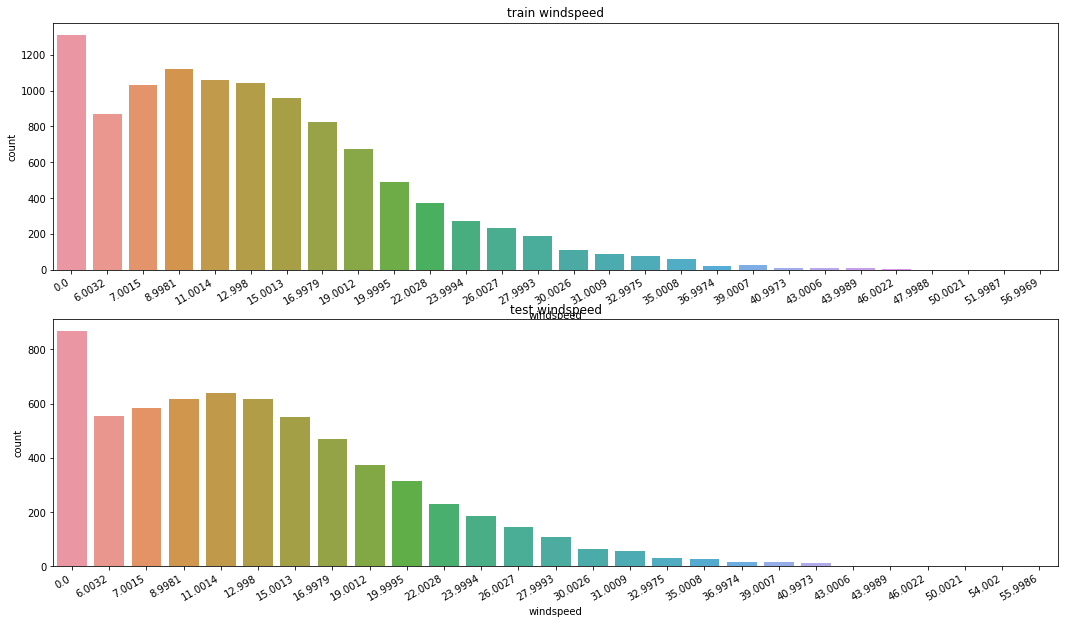

In [17]:
#windspeed 풍속에 0 값이 가장 많다 -> 잘못 기록된 데이터 고쳐줄 필요 있음
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [20]:
#풍속의 0값에 특정값을 넣어준다. - 머신러닝으로 예측해서

#풍속이 0인 것과 아닌 것의 세트 나누기
trainWind0 = train.loc[train['windspeed']==0]
trainWindNot0 = train.loc[train['windspeed']!=0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [23]:

from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
  #풍속이 0인 것과 아닌 것 구분
  dataWind0 = data.loc[data['windspeed']==0]
  dataWindNot0 = data.loc[data['windspeed']!=0]

  #풍속 예측할 피처 선택
  wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

  #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
  dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')

  #랜덤포레스트 분류기 사용
  rfModel_wind = RandomForestClassifier()

  #wCol에 있는 피처의 값을 바탕으로 풍속을 학습
  rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'] )

  #학습한 값 바탕으로 풍속이 0으로 기록된 데이터의 풍속 예측
  wind0Values = rfModel_wind.predict(X=dataWind0[wCol])

  #값을 다 예측 후 비교해보기위해 예측한 값을 넣어 줄 데이터프레임 새로 만듦
  predictWind0 = dataWind0
  predictWindNot0 = dataWindNot0

  #값이 0으로 기록된 풍속에 대해 예측한 값 넣기
  predictWind0['windspeed'] = wind0Values

  #dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합침
  data = predictWindNot0.append(predictWind0)

  #풍속의 데이터타입을 float로 지정
  data['windspeed'] = data['windspeed'].astype('float')

  data.reset_index(inplace=True)
  data.drop('index', inplace=True, axis=1)

  return data

In [28]:
#0값을 조정
train = predict_windspeed(train)
# test = predict_windspeed(test)

#windspeed의 0값을 조정한 데이터 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

ValueError: ignored

# Feature Selection

* 신호와 소음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [29]:
#범주형 feature의 type을 category로 변경
categorical_feature_names = ['season', 'holiday', 'workingday', 'weather', 'dayofweek', 'month', 'year', 'hour']

for var in categorical_feature_names:
  train[var] = train[var].astype('category')
  test[var] = test[var].astype('category')

In [30]:
feature_names = ['season', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'hour', 'dayofweek', 'holiday', 'workingday']

In [32]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [33]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [34]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

# Score


*   RMSLE
*   



In [35]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
  #넘파이로 배열 형태로 바꿔줌
  predicted_values = np.array(predicted_values)
  actual_values = np.array(actual_values)

  #예측값과 실제값에 1을 더하고 로그 씌워준다
  #1을 더하는 이유는 0일때 마이너스무한대가 되기 때문
  log_predict = np.log(predicted_values+1)
  log_actual = np.log(actual_values+1)

  #위에서 계산한 예측값에서 실제값 빼주고 제곱 해줌
  difference = log_predict - log_actual
  # difference = (log_predict - log_actual) ** 2
  difference - np.square(difference)

  #평균을 낸다
  mean_difference = difference.mean()

  #다시 루트 씌운다
  score = np.sqrt(mean_difference)

  return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

# Cross Validation 교차 검증

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

# RandomForest

In [38]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [39]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()

#0에 근접할수록 좋은 데이터
print('Score = {0:.5f}'.format(score))

CPU times: user 4.51 s, sys: 870 ms, total: 5.38 s
Wall time: 31.4 s
Score = nan


#Train

In [40]:
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [41]:
#예측
predictions = model.predict(X_test)

print(predictions.shape)
predictions[:10]

(6493,)


array([ 12.48,   5.09,   4.  ,   3.44,   2.98,   6.3 ,  38.29, 105.26,
       236.85, 136.58])

[Text(0.5, 1.0, 'test')]

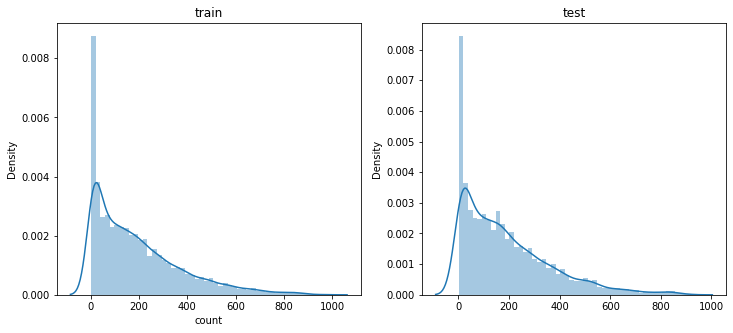

In [45]:
#예측한 데이터 시각화
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(12,5)

sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title='train')

sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title='test')

# Submit

In [47]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = predictions

print(submission.shape)
submission.head()


(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.48
1,2011-01-20 01:00:00,5.09
2,2011-01-20 02:00:00,4.00
3,2011-01-20 03:00:00,3.44
4,2011-01-20 04:00:00,2.98
